*Pour accéder à ce Jupyter Notebook au format .ipynb, suivre [ce lien](...). Pour plus d'infos, [consulter cette page](https://linkingthepast.org/about/).*

# Effectuer des requêtes SPARQL fédérées


Cette étape vise à explorer comment nous pouvons interroger simultanément plusieurs points d'accès SPARQL.


## Objectif

Le but est de tester l'utilisation de requêtes SPARQL fédérées, pour croiser les données de la Wikibase avec des données externes. En l'occurence, le test présenté ci-dessous vise à compléter les données sur une personne à l'aide de donnée issues de Wikidata.

## Inspiration

Les exemples ci-dessous sont inspirés de ces deux requêtes fédérées : 
- [Biodiversity + Wikidata](https://tinyurl.com/ydawxohx)
- [Wikidata + Nobelprize](https://w.wiki/VW7)

## Fonctionnement 

L'idée est d'utiliser le [service de requête](https://query-adochs.arch.be/) de la Wikibase comme pour une requête classique, puis d'utiliser une jointure, c'est-à-dire un pivot permettant de faire le lien entre les données de la Wikibase et les données de Wikidata (dans la cas présent, il s'agit de l'identifiant Wikidata stocké dans la Wikibase à l'aide de propriété P2). La récupération des données complémentaires se fait à l'aide de la "clause" SERVICE, qui permet d'interroger simultanément un autre point d'accès SPARQL.


### *Nota bene*
Ce document vise à présenter le fonctionnement général de telles requêtes, les exemples sont donc illustrés à l'aide du code de la requête et de résultats présentés sous forme de captures d'écran pour une meilleure lisibilité, mais il est bien sûr également possible de lancer ces requêtes à l'aide d'un script Python basé sur le module SPARQLWrapper, à l'instar de ce que nous avons présenté [ici](https://linkingthepast.org/reuse/).

## Exemple 1 

Le but ici est de récupérer une liste des personnes stockées dans la Wikibase *(wbt:P1 wb:Q3617)*, accompagnées des institutions possédant des archives à leur sujet [(wdt:P485)](https://www.wikidata.org/wiki/Property:P485) selon Wikidata, ainsi que du nom *(label)* de ces institutions si l'information est disponible.

L'URI de l'identifiant Wikidata *(wbt:P2)* est utilisée comme jointure pour récupérer l'information désirée, tandis que la partie concernée de la requête est transmise au point d'accès de Wikidata à l'aide de la clause SERVICE et de [l'URL concernée ](https://query.wikidata.org/bigdata/namespace/wdq/).

Les informations sur les institutions possédant des archives au sujet de cette personne (URI Wikidata et nom de l'institution) sont regroupées à l'aide de GROUP_CONTACT pour éviter d'avoir une multiplication de lignes pour une même personne en cas de valeurs multiples.

### Requête SPARQL Exemple 1

*Rappel*: le code ci-dessous est montré à titre purement illustratif mais ne peut pas être lancé dans le cadre de ce Jupyter Notebook. 

Pour lancer la requête, [suivre ce lien](https://tinyurl.com/ybhcfxds). 

In [ ]:
PREFIX wb: <https://adochs.arch.be/entity/>
PREFIX wbt: <https://adochs.arch.be/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wdq: <https://query.wikidata.org/bigdata/namespace/wdq/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?personne ?personneLabel ?wikidata_iri (GROUP_CONCAT(DISTINCT ?archives; SEPARATOR = "; ") AS ?archives_URI) 
 (GROUP_CONCAT(DISTINCT ?archivesLabel; SEPARATOR = "; ") AS ?archives_label) 

WHERE {
  ?personne wbt:P1 wb:Q3617.
  ?personne wbt:P2 ?identifiantWikidata. 
  BIND (URI(CONCAT("http://www.wikidata.org/entity/",?identifiantWikidata)) AS ?wikidata_iri)
 SERVICE wdq:sparql {
  ?wikidata_iri wdt:P485 ?archives.
  OPTIONAL {?archives rdfs:label ?archivesLabel.
  FILTER(LANG(?archivesLabel) = "[AUTO_LANGUAGE]").}
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "fr,nl,en,de" } .
}

GROUP BY ?personne ?personneLabel ?wikidata_iri ?archives_URI ?archives_label

### Résultats Exemple 1

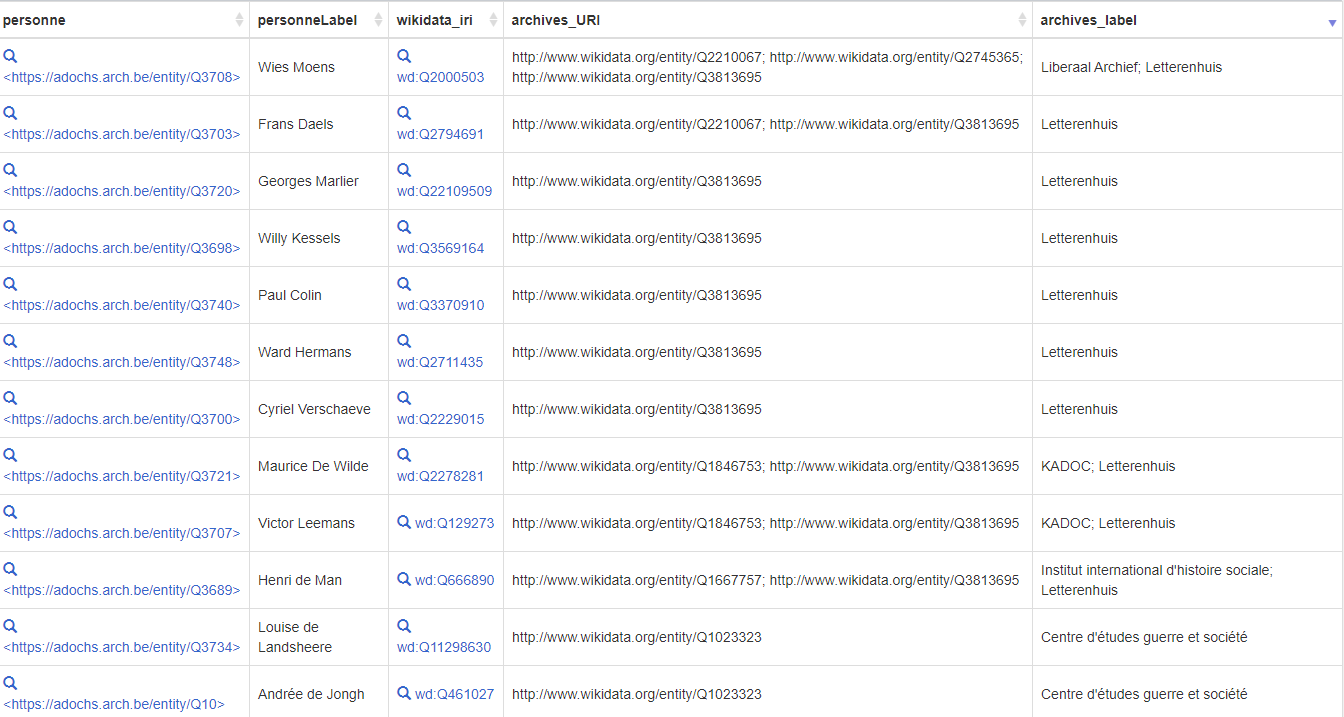

__En bref__, les résultats nous donnent à voir :
- l'URI Wikibase de la personne concernée
- son label
- l'URI Wikidata permettant de faire le pivot entre l'instance Wikibase et Wikidata
- les URI Wikidata correspondant aux institutions possédant des archives *au sujet de* cette personne
- les labels de ces institutions s'ils sont disponibles en français, néerlandais, anglais ou allemand

## Vue d'ensemble (exemple 1)

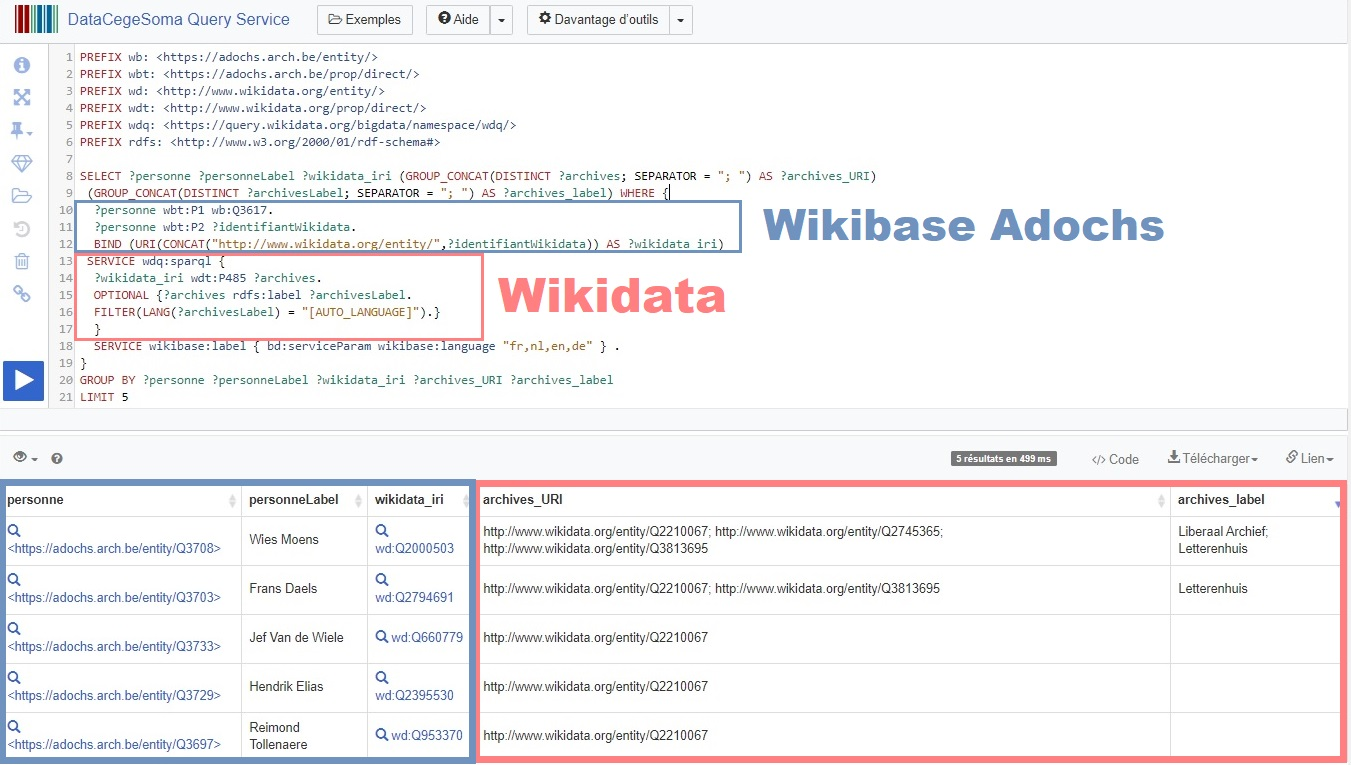

## Exemple 2

Le but ici est de récupérer, pour une personne donnée (pour des raisons de performance, cf. Limites ci-dessous), les informations présentes sur Wikidata au sujet de ses éventuelles *occupation*, affiliation à un parti politique, distinction reçue, et des éventuelles institutions possédant des archives à son sujet (cf. Exemple 1).

L'URI de l'identifiant Wikidata *(wbt:P2)* est à nouveau utilisée comme jointure pour récupérer l'information désirée, tandis que la partie concernée de la requête est transmise au point d'accès de Wikidata à l'aide de la clause SERVICE et de [l'URL concernée ](https://query.wikidata.org/bigdata/namespace/wdq/).

Les valeurs multiples sont regroupées dans une même cellule à l'aide de GROUP_CONTACT.

### Requête SPARQL Exemple 2

*Rappel :* le code ci-dessous est montré à titre purement illustratif mais ne peut pas être lancé dans le cadre de ce Jupyter Notebook. 

Pour lancer la requête, [suivre ce lien](https://tinyurl.com/y868bhgu). 

In [ ]:
PREFIX wb: <https://adochs.arch.be/entity/>
PREFIX wbt: <https://adochs.arch.be/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wdq: <https://query.wikidata.org/bigdata/namespace/wdq/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?personne ?personneLabel ?wikidata_iri (GROUP_CONCAT(DISTINCT ?occupationLabel; SEPARATOR = " ; ") AS ?occupations) 
(GROUP_CONCAT(DISTINCT ?partiLabel; SEPARATOR = " ; ") AS ?partis) 
(GROUP_CONCAT(DISTINCT ?distinctionLabel; SEPARATOR = " ; ") AS ?distinctions)
(GROUP_CONCAT(DISTINCT ?archiveLabel; SEPARATOR = " ; ") AS ?archives)
WHERE {
  
  VALUES ?personne {wb:Q3659}
  ?personne wbt:P2 ?identifiantWikidata. 
  
  BIND (URI(CONCAT("http://www.wikidata.org/entity/",?identifiantWikidata)) AS ?wikidata_iri)
 
  SERVICE wdq:sparql {
    OPTIONAL {
      ?wikidata_iri wdt:P106 ?occupation.
      ?occupation rdfs:label ?occupationLabel.
      FILTER((LANG(?occupationLabel)) = "[AUTO_LANGUAGE]")
    }
    OPTIONAL {
      ?wikidata_iri wdt:P102 ?parti.
      ?parti rdfs:label ?partiLabel.
      FILTER((LANG(?partiLabel)) = "[AUTO_LANGUAGE]")
    }
    OPTIONAL {
      ?wikidata_iri wdt:P166 ?distinction.
      ?distinction rdfs:label ?distinctionLabel.
      FILTER((LANG(?distinctionLabel)) = "[AUTO_LANGUAGE]")
    }
       OPTIONAL {
      ?wikidata_iri wdt:P485 ?archive.
      ?archive rdfs:label ?archiveLabel.
      FILTER((LANG(?archiveLabel)) = "[AUTO_LANGUAGE]")
    }
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr,en". }
}
GROUP BY ?personne ?personneLabel ?wikidata_iri ?occupations ?partis ?distinctions ?archives



### Résultats Exemple 2

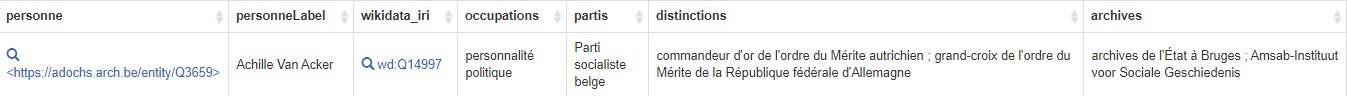

## Vue d'ensemble (exemple 2)

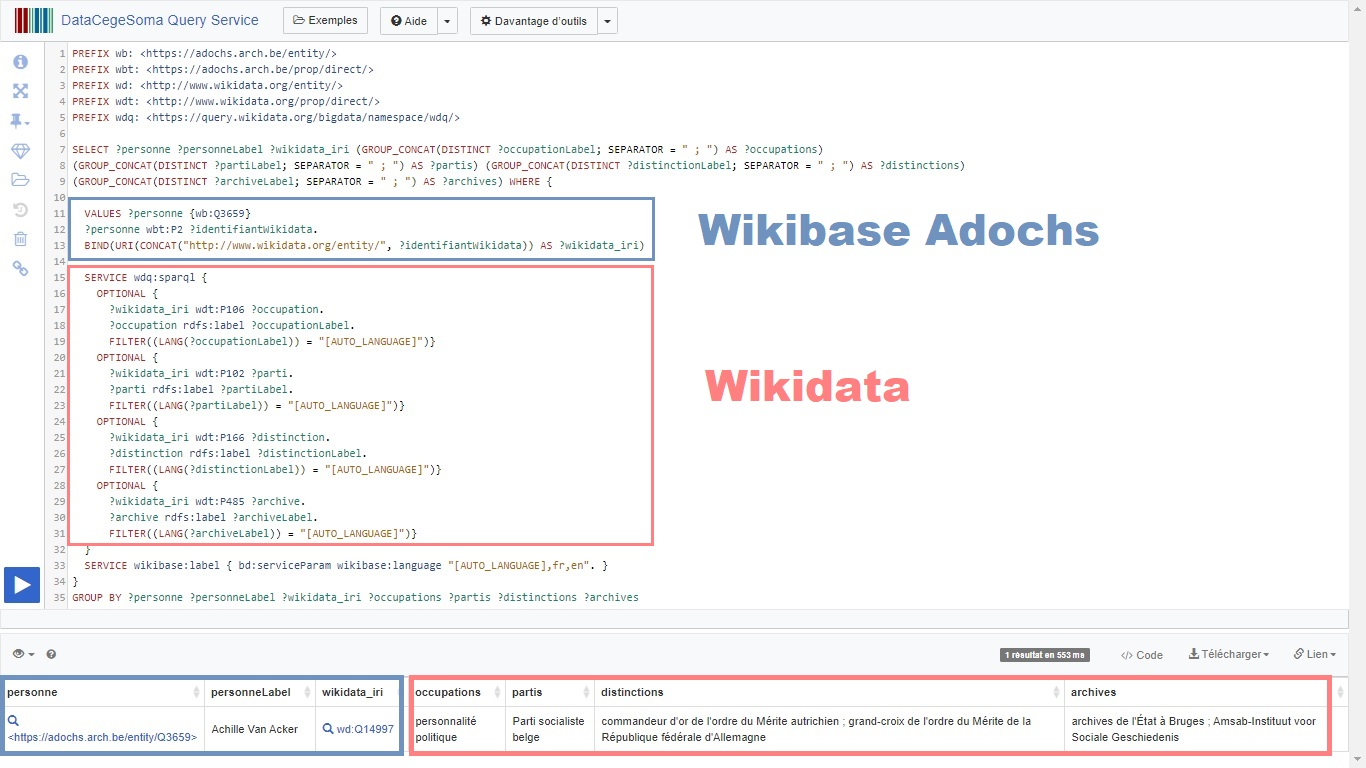

## Limites

Deux principales limites doivent être relevées ici : 

- la richesse des résultats est directement conditionnée par l'étendue des données ayant été encodées sur Wikidata (ainsi, une absence de [distinctions reçues](https://www.wikidata.org/wiki/Property:P166), ne signifie pas forcément que la personne n'en a reçue aucune...), mais également par la proportion d'entités de la Wikibase ayant pu être réconciliées avec  l'identifiant Wikidata correspondant 
- lors de nos premiers tests, certains problèmes de performance ont été constatés, nous conduisant à limiter le nombre de résultats à afficher

## Aller plus loin

Le processus qui a été illustré ici avec les données issues de Wikidata pourrait également être utilisé pour interroger d'autres points d'accès SPARQL - sous réserve de disposer de données de *jointure* entre ces jeux de données - comme par exemple des points d'accès spécialisés contenant des données liées à la Seconde Guerre mondiale. C'est le par exemple de [dati.CDEC](http://dati.cdec.it/indiceEN.html), qui a publié *a database subset of names of Jews deported from Italy* interrogeable à l'aide d'un [point d'accès SPARQL](http://lod.xdams.org/sparql).

Cependant, pour des raisons de sécurité, seuls les points d'accès SPARQL ayant été spécifiquement *whitelisted* dans les paramètres de configuration de la Wikibase peuvent être interrogés, cela nécessiterait donc quelques ajustements préalables.
